In [25]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tqdm
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [3]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [4]:
DATASET_PATH = os.path.abspath("./dataset/datasetFiltered")

TRAIN_CSV = os.path.abspath("./data/processed/train/10000Train.csv")
VALIDATION_CSV = os.path.abspath("./data/processed/validation/10000Validation.csv")
TEST_CSV = os.path.abspath("./data/processed/test/10000Test.csv")

RESULT_CSV = os.path.abspath("./reports/model_coberture/")

print(f"DATASET_PATH:   {DATASET_PATH}")
print(f"TRAIN_CSV:      {TRAIN_CSV}")
print(f"VALIDATION_CSV: {VALIDATION_CSV}")
print(f"TEST_CSV:       {TEST_CSV}")
print(f"RESULT_JSON:    {RESULT_CSV}")


DATASET_PATH:   /Users/carlos/WORKSPACE/MegaClassifier/dataset/datasetFiltered
TRAIN_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/processed/train/10000Train.csv
VALIDATION_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/processed/validation/10000Validation.csv
TEST_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/processed/test/10000Test.csv
RESULT_JSON:    /Users/carlos/WORKSPACE/MegaClassifier/reports/model_coberture


In [5]:
train_csv = dt.load_from_csv(TRAIN_CSV)
vali_csv = dt.load_from_csv(VALIDATION_CSV)
test_csv = dt.load_from_csv(TEST_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/train/10000Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/validation/10000Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/processed/test/10000Test.csv has been successfully opened.


In [6]:
columns = ["file_name", "label"]

data = []
for _, row in train_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row["file_name"])
    label = row["label"]
    data.append([file_name, label])
train_dataset = pd.DataFrame(data, columns=columns)
train_dataset["label"] = train_dataset["label"].astype(str)

data = []
for _, row in vali_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row["file_name"])
    label = row["label"]
    data.append([file_name, label])
vali_dataset = pd.DataFrame(data, columns=columns)
vali_dataset["label"] = vali_dataset["label"].astype(str)

data = []
for _, row in test_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row["file_name"])
    label = row["label"]
    data.append([file_name, label])
test_dataset = pd.DataFrame(data, columns=columns)
test_dataset["label"] = test_dataset["label"].astype(str)

In [7]:
img_weight = 224
img_height = 224

batch_size = 32

seed = 42

epochs = 50

In [8]:
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, brightness_range=[0.8, 1.2]
)
datagen_val_test = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=seed,
)

val_generator = datagen_val_test.flow_from_dataframe(
    dataframe=vali_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=seed,
)

test_generator = datagen_val_test.flow_from_dataframe(
    dataframe=test_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 20732 validated image filenames belonging to 2 classes.
Found 4442 validated image filenames belonging to 2 classes.
Found 4444 validated image filenames belonging to 2 classes.


Ejemplos aleatorios del conjunto de entrenamiento (redimensionadas):


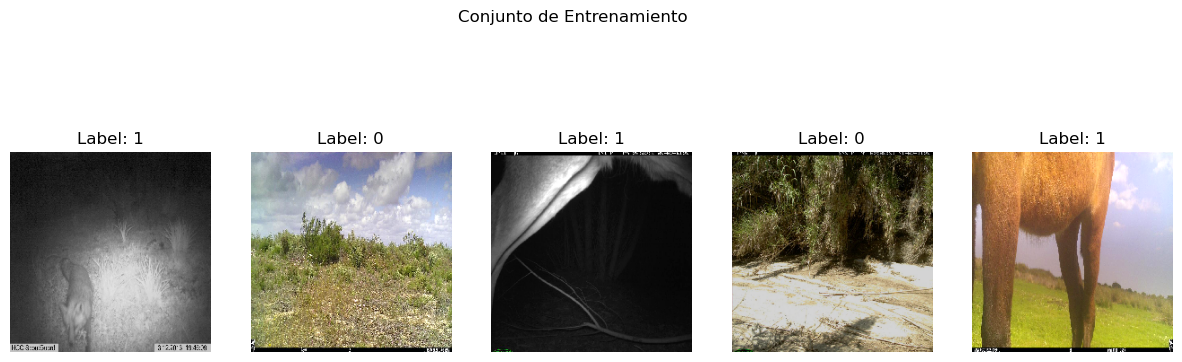


Ejemplos aleatorios del conjunto de validación (redimensionadas):


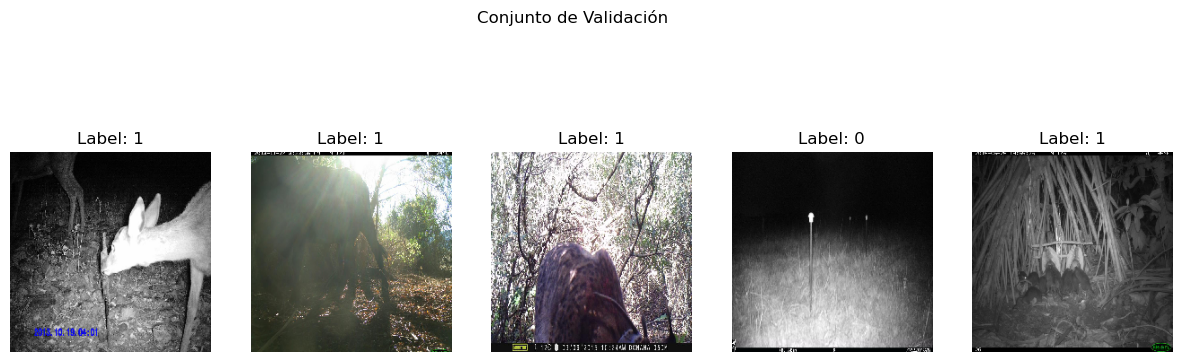


Ejemplos aleatorios del conjunto de prueba (redimensionadas):


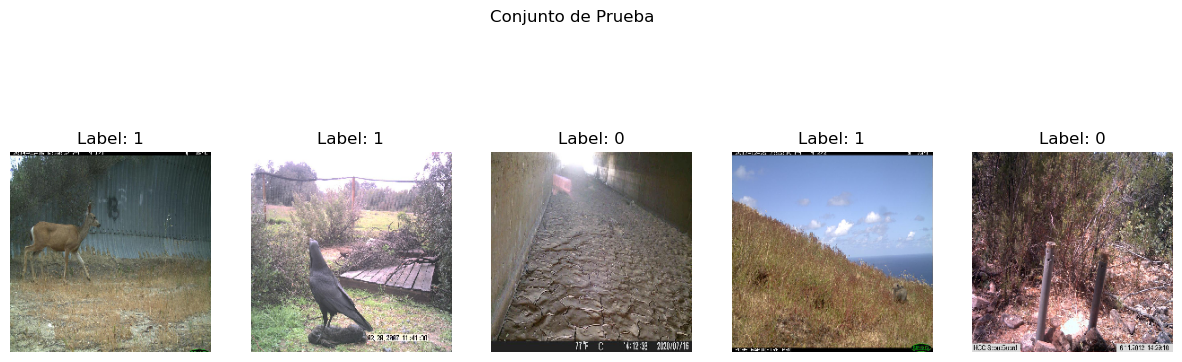

In [40]:
def show_random_images_from_generator(generator, title):
    images, labels = next(
        generator
    )  # Toma un batch de imágenes y etiquetas del generador
    plt.figure(figsize=(15, 5))
    for i in range(5):  # Muestra 5 imágenes del batch
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_random_images_from_generator(train_generator, "Conjunto de Entrenamiento")
show_random_images_from_generator(val_generator, "Conjunto de Validación")
show_random_images_from_generator(test_generator, "Conjunto de Prueba")

In [15]:
mobilenetV2 = MobileNetV2(
    include_top=False, input_shape=(img_weight, img_height, 3), weights="imagenet"
)

mobilenetV2.trainable = False

model = Sequential(
    [
        mobilenetV2,
        GlobalAveragePooling2D(),
        Dense(1, activation="sigmoid", name="Output_Layer"),
    ],
    name="MobileNetV2_v1",
)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "MobileNetV2_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 Output_Layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
checkpoint = ModelCheckpoint(
    "./models/CNNs/original_MobileNetV2_V1.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1,
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="min",
    verbose=1,
    restore_best_weights=True,
)

tensorBoard = TensorBoard(log_dir="./logs/original/MobileNetV2/version_1")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=2000 // batch_size,
    callbacks=[checkpoint, early_stop, tensorBoard],
    # verbose=2,
)

Epoch 1/100
62/62 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.7571
Epoch 1: val_loss improved from inf to 0.37320, saving model to ./models/CNNs/original_MobileNetV2_V1.h5
62/62 [==============================] - 38s 611ms/step - loss: 0.4895 - accuracy: 0.7571 - val_loss: 0.3732 - val_accuracy: 0.8323
Epoch 2/100
62/62 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8407
Epoch 2: val_loss improved from 0.37320 to 0.33430, saving model to ./models/CNNs/original_MobileNetV2_V1.h5
62/62 [==============================] - 38s 611ms/step - loss: 0.3496 - accuracy: 0.8407 - val_loss: 0.3343 - val_accuracy: 0.8519
Epoch 3/100
62/62 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8518
Epoch 3: val_loss improved from 0.33430 to 0.31538, saving model to ./models/CNNs/original_MobileNetV2_V1.h5
62/62 [==============================] - 37s 606ms/step - loss: 0.3312 - accuracy: 0.8518 - val_loss: 0.3154 - val_accuracy: 0.8

KeyboardInterrupt: 

In [10]:

def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()


plot_training_history(history)

NameError: name 'history' is not defined

In [16]:
from tensorflow.keras.models import load_model

mobilenetv2_v1 = load_model("./models/CNNs/original_MobileNetV2_V1.h5")
evaluate = mobilenetv2_v1.evaluate(test_generator)


2024-10-20 19:54:38.869031: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


139/139 [==============================] - 46s 324ms/step - loss: 0.2254 - accuracy: 0.9086


In [20]:
test_labels = test_generator.classes

predict = mobilenetv2_v1.predict(test_generator)
predict_flatten = predict.flatten()

Random Classifier: ROC AUC=0.5
MobileNetV2 V1: ROC AUC=0.9656


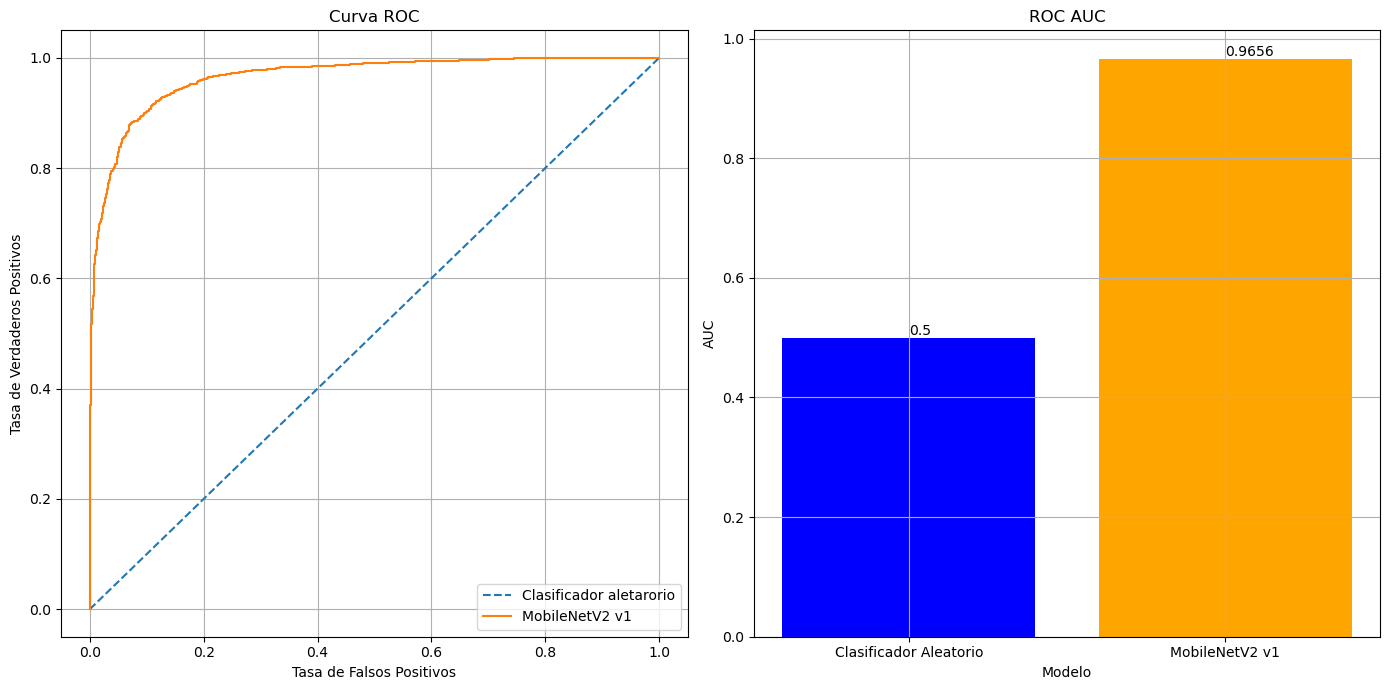

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Generar predicciones aleatorias
random_flatten = np.zeros_like(test_labels)

# Calcular el AUC
random_auc = roc_auc_score(test_labels, random_flatten)
mobilenetv2_auc = roc_auc_score(test_labels, predict_flatten)

print("Random Classifier: ROC AUC=%.1f" % (random_auc))
print("MobileNetV2 V1: ROC AUC=%.4f" % (mobilenetv2_auc))

# Calcular la curva ROC
random_false_positive_rate, random_true_positive_rate, _ = roc_curve(
    test_labels, random_flatten
)
mobilenetv2_false_positive_rate, mobilenetv2_true_positive_rate, _ = roc_curve(
    test_labels, predict_flatten
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot ROC curve
ax1.plot(
    random_false_positive_rate,
    random_true_positive_rate,
    linestyle="--",
    label="Clasificador aletarorio",
)
ax1.plot(
    mobilenetv2_false_positive_rate,
    mobilenetv2_true_positive_rate,
    # marker=".",
    label="MobileNetV2 v1",
)
ax1.set_title("Curva ROC")
ax1.set_xlabel("Tasa de Falsos Positivos")
ax1.set_ylabel("Tasa de Verdaderos Positivos")
ax1.legend()
ax1.grid(True)

# Plot AUC values
auc_labels = ["Clasificador Aleatorio", "MobileNetV2 v1"]
auc_values = [random_auc, mobilenetv2_auc]
bars = ax2.bar(auc_labels, auc_values, color=["blue", "orange"])
ax2.set_title("ROC AUC")
ax2.set_xlabel("Modelo")
ax2.set_ylabel("AUC")
ax2.grid(True)

for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), va="bottom")

plt.tight_layout()
plt.show()


In [32]:
from scipy.special import expit

# Convertir las predicciones a clases binarias usando la función sigmoide
predicted_classes = (expit(predict_flatten) >= 0.5).astype(int)

# Mostrar las primeras 10 predicciones y sus clases correspondientes
for i in range(10):
    print(
        f"Predicción: {predict_flatten[i]:.4f}, Clase predicha: {predicted_classes[i]}"
    )

Predicción: 0.6485, Clase predicha: 1
Predicción: 0.9957, Clase predicha: 1
Predicción: 0.9996, Clase predicha: 1
Predicción: 0.9998, Clase predicha: 1
Predicción: 0.0822, Clase predicha: 1
Predicción: 0.0999, Clase predicha: 1
Predicción: 0.9996, Clase predicha: 1
Predicción: 0.3088, Clase predicha: 1
Predicción: 0.0753, Clase predicha: 1
Predicción: 0.2707, Clase predicha: 1


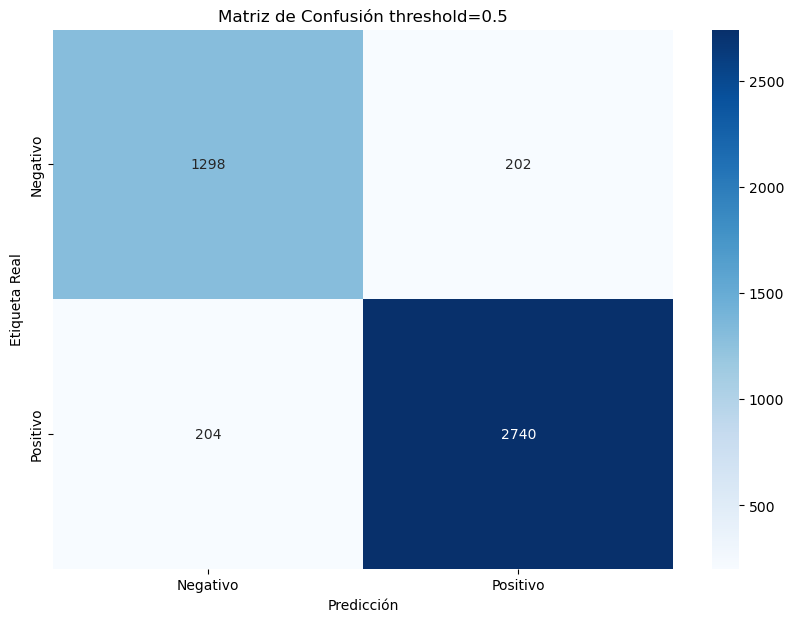

In [33]:
# Convertir las probabilidades de predicción en etiquetas de clase (0 o 1) con un umbral de 0.5
predicted_classes = (predict > 0.5).astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(test_labels, predicted_classes)

# Dibujar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negativo", "Positivo"],
    yticklabels=["Negativo", "Positivo"],
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión threshold=0.5")
plt.show()

In [14]:
loss, accuracy = evaluate

df_results = pd.DataFrame(
    {
        "False Positive Rate": mobilenetv2_false_positive_rate,
        "True Positive Rate": mobilenetv2_true_positive_rate,
        "AUC": [mobilenetv2_auc] * len(mobilenetv2_false_positive_rate),
        "Loss": [loss] * len(mobilenetv2_false_positive_rate),
        "Accuracy": [accuracy] * len(mobilenetv2_false_positive_rate),
    }
)

os.makedirs("./logs/original/MobileNetV2/version_1/test", exist_ok=True)
df_results.to_csv(
    "./logs/original/MobileNetV2/version_1/test/mobilenetv2_v1_results.csv", index=False
)